In [1]:
import sys 
import pdb
import torch
import torch.utils.data
from torchvision import datasets, transforms
import torch.optim as optim
from attrdict import AttrDict
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import importlib
import numpy as np

#sys.path.append('../data/Hasy/')
sys.path.append('../src/codebase')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

In [3]:
%load_ext autoreload 
%autoreload 2

### Set Params 

In [ ]:
outdir = '../src/out/mnist/'
ckpdir = '../src/checkpoints/mnist/'

# Just needed for data loading, really
args = AttrDict({'batch_size': 256,
                 'lr': 0.001,
                 'momentum': 0.5,
                 'epochs': 10,
                 'log_interval': 10})

# Reproducibility
np.random.seed(2018)

### Load Data

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False)

In [7]:
# Grab a batch for experiments
batch_x, batch_y = next(iter(train_loader))

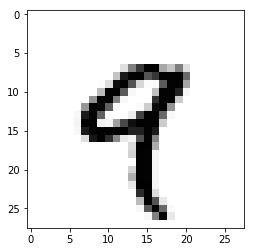

In [8]:
idx = 4
plt.imshow(batch_x[idx].squeeze(), cmap = 'Greys')

### Load Classifier

In [9]:
from models import image_classifier

classifier = torch.load(os.path.join(ckpdir, "classif.pth"))

#classifier = image_classifier.load(os.path.join(ckpdir, "classif.pth"))

AttributeError: Can't get attribute 'Net' on <module 'models' from '../src/codebase/models.py'>

### Load Masked Classifier

In [12]:
import models
importlib.reload(models)
from models import masked_image_classifier

mask_size = (7,7)

## If cpu (old loading format)
model_path = os.path.join(ckpdir, "mask_model_{}x{}.pth").format(*mask_size)
mask_model = torch.load(model_path)

## If gpu (old loading format)
model_path = os.path.join(ckpdir, "mask_model_{}x{}.gpu.pth").format(*mask_size)
mask_model = torch.load(model_path, map_location=lambda storage, location: storage)

# New loading function (both cpu and gpu)
#mask_model = masked_image_classifier.load(model_path)


AttributeError: Can't get attribute 'masked_mnist_classifier' on <module 'models' from '../src/codebase/models.py'>

### Explain!

In [ ]:
importlib.reload(matplotlib)
matplotlib.use('PS')

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

import utils
importlib.reload(utils)

import attrib_optim
importlib.reload(attrib_optim)
from attrib_optim import MCExplainer

classes_tex = [str(i) for i in range(10)]

crit_alpha = 1
crit_p = 2
Exp = MCExplainer(classifier, mask_model, classes = classes, crit_alpha = crit_alpha,
                  crit_p = crit_p, plot_type = 'treemap')

# 12, 25, 30
idx = 63
x  = batch_x[idx:idx+1]
print(classes_tex[batch_y[idx].item()])

fx = classifier(x)
p, pred = fx.max(1)

plt.imshow(x.squeeze(), cmap='Greys')
plt.title('Prediction: ' + classes_tex[pred] + ' (class no.{})'.format(pred.item()), fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.show()


e = Exp.explain(x, pred.item(), verbose = 0 , show_plot = 0)
save_path = None
save_path = os.path.join(outdir, 'expl_id-{}_alpha-{}.pdf'.format(idx, crit_alpha, crit_p))
e.plot(save_path = save_path)